In [9]:
pip install tensorflow

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 3.4/376.0 MB 16.7 MB/s eta 0:00:23
    --------------------------------------- 6.8/376.0 MB 16.1 MB/s eta 0:00:23
   - -------------------------------------- 9.7/376.0 MB 15.9 MB/s eta 0:00:24
   - -------------------------------------- 13.6/376.0 MB 16.1 MB/s eta 0:00:23
   - -------------------------------------- 17.0/376.0 MB 16.3 MB/s eta 0:00:23
   -- ------------------------------------- 21.0/376.0 MB 16.8 MB/s eta 0:00:22
   -- ------------------------------------- 24.9/376.0 MB 17.0 MB/s eta 0:00:21
   --- ------------------------------------ 28.8/376.0 MB 17.2 MB/s eta 0:00:21
   --- ------------------------------------ 32.8/376.0 MB 17.3 MB/s eta 0:00:20
   --- ------------------------------------ 35.7/376.0 MB 17.4 MB/s eta 0:00:20
   --- ------------------------------------ 37.0/376.0 MB 16.2 MB/s eta 0:00:21
   ---- ----------------------------------- 38.3/376

In [1]:
import numpy as np

In [2]:
# 출력층의 WX+b를 z라고 가정
z = np.array([0.3, 2.9, 4.0])

# 분자 부분 계산
exp_z = np.exp(z)

# 분모 부분 계산
sum_exp_z = np.sum(exp_z)

pred_y = exp_z / sum_exp_z
pred_y

array([0.01821127, 0.24519181, 0.73659691])

In [3]:
np.sum(pred_y)

1.0

In [4]:
def softmax(z):
  exp_z = np.exp(z) # 분자
  sum_exp_z = np.sum(exp_z) # 분모
  pred_y = exp_z / sum_exp_z

  return pred_y

In [5]:
big_z = [1000, 900, 1100]

softmax(big_z)

C:\Users\user\AppData\Local\Temp\ipykernel_19332\2062636371.py:2: RuntimeWarning: overflow encountered in exp
  exp_z = np.exp(z) # 분자
C:\Users\user\AppData\Local\Temp\ipykernel_19332\2062636371.py:4: RuntimeWarning: invalid value encountered in divide
  pred_y = exp_z / sum_exp_z


array([nan, nan, nan])

In [6]:
# C prime은 보통 원소 중 가장 큰 값에 -1을 곱한 값을 사용
c = -np.max(big_z)
big_z + c

array([-100, -200,    0])

In [7]:
# 튜닝된 소프트맥스
def softmax(z):
  c = np.max(z)

  exp_z = np.exp(z - c)
  sum_exp_z = np.sum(exp_z)

  pred_y = exp_z / sum_exp_z
  return pred_y

softmax(big_z)

array([3.72007598e-44, 1.38389653e-87, 1.00000000e+00])

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# mnist 데이터 세트 로딩
from tensorflow.keras import datasets

mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
X_train.shape

(60000, 28, 28)

(28, 28)


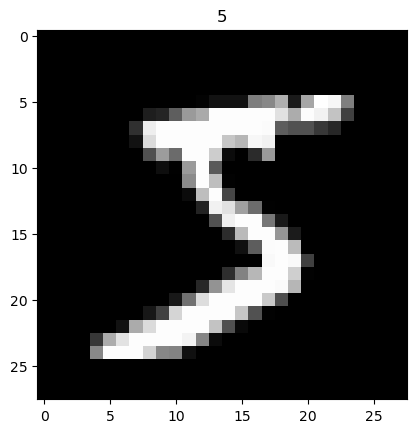

In [12]:
test_image = X_train[0]
print(test_image.shape)

plt.imshow(test_image, 'gray') # 채널에 대한 정보가 없으면 흑백
plt.title(y_train[0])
plt.show()

In [13]:
test_image.flatten().shape

(784,)

In [14]:
# 배치 정보 부여하기. (N, M) -> (1, 784)
test_image.reshape(1, -1).shape

(1, 784)

In [15]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 테스트 데이터만 가져오기
def get_test_data():
  _, (X_test, t_test) = mnist.load_data()

  # YOUR CODE HERE
  # 단순히 X_test로 리턴하는게 아닌 (N, M) 형태로 리턴하기

  IMAGE_COUNT = X_test.shape[0] # shape[0] : 이미지개수 (X_test.shape -> (10000,28,28))

  X_test_reshaped = X_test.reshape(IMAGE_COUNT, -1)

  return X_test_reshaped, t_test

# 이미 학습이 완료된 신경망 데이터 가져오기(sample_weight.pkl)
def init_network():
  import pickle
  with open("./sample_weight.pkl", "rb") as f:
    network = pickle.load(f)

  return network

In [18]:
network = init_network()
network["W1"].shape


(784, 50)

In [19]:
network["W2"].shape

(50, 100)

In [20]:
network["W3"].shape

(100, 10)

In [22]:
def predict(network, x) :
    """
        network : 가중치가 들어있는 신경망 W1 ~ W3
        x : 신경망에 입력되는 데이터
    """
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    b1, b2, b3 = network["b1"], network["b2"], network["b3"]

    # x : 원래 28 x 28 형식의 이미지, 이것을 평탄화 시켜 784차원 벡터로 만듦
    # W1 : 뉴런의 개수가 몇 개인지는 몰라도
    #        입력되는 데이터의 개수인 784개의 입력을 각각 받는다는 것은 알 수 있다.
    
    # 1층 FCL 구현
    z1 = x @ W1 + b1 # 선형 조합 연산 
    a1 = sigmoid(z1) # 선형 조합된 연산에 비선형성을 부여

    # 2층
    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2)

    # 3층(출력층)
    z3 = a2 @ W3 + b3
    pred = softmax(z3)

    return pred

# 추론 ( inference )
- 순전파(Forward Propagation)에 해당한다. 
    - 입력 데이터 -> 은닉층 -> 출력층
    - (N, 784) -> 은닉층 -> (N, 10)
- 예측 과정.

In [24]:
X, y = get_test_data()

# 한 장의 이미지만 가져와서 테스트 해보기
test_image, test_target =  X[0], y[0]

In [25]:
test_image.shape

(784,)

In [26]:
# 배치 정보 부여
test_image = test_image.reshape(1, -1)
test_image.shape

(1, 784)

In [27]:
# 네트워크 생성
model = init_network()

test_result =  predict(model, test_image)
test_result

C:\Users\user\AppData\Local\Temp\ipykernel_19332\1185480774.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


array([[4.2879042e-06, 4.5729357e-07, 1.8486280e-04, 8.3605024e-05,
        1.5084704e-07, 6.3182267e-07, 4.5782045e-10, 9.9919468e-01,
        3.8066935e-07, 5.3083047e-04]], dtype=float32)

In [28]:
test_result.sum()

0.9999999

In [29]:
# 확률이 가장 높은 인덱스(클래스) 구해내기
np.argmax(test_result)

7

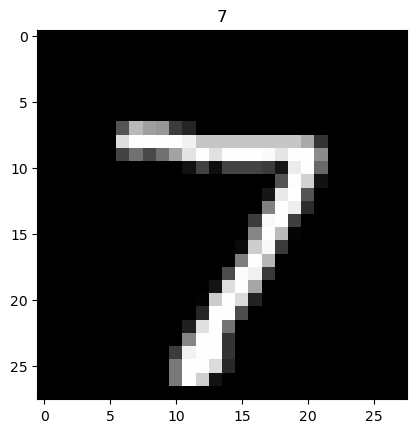

In [30]:
plt.imshow(test_image.reshape(28, 28), 'gray')
plt.title(test_target)
plt.show()

# 모델의 예측 정확도 확인

In [ ]:
# 한 장씩 예측해서 정확도 확인
X, y = get_test_data()

model = init_network()
acc_count = 0 #  정답을 맞춘 개수를 저장 ( 예를 들어 1만장 중 500장 맞았으면 500 )

# 이미지를 한 장씩 꺼내서 테스트
for i in range(len(X)) :
    image = X[i]

    pred = predict(model, image) # 이미지 한 장 마다의 소프트맥스 결과물 (10, )
    pred = np.argmax(pred) # 확률이 가장 높은 원소의 인덱스( 예측 클래스 )

    acc_count += (pred == y[i]) # 정답(y)과 예측(pred)이 맞으면 +1

float(acc_count / len(X)) # 맞춘 데이터 개수 / 전체 데이터 개수

C:\Users\user\AppData\Local\Temp\ipykernel_19332\1185480774.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9207

위 코드의 단점
- 1만장의 이미지를 한장씩 예측하고 있다.
- 시간이 오래걸린다는 이야기다.

어떻게 해결할수 있을까?
- BATCH를 사용해서 한장씩이 아닌 데이터의 묶음으로 예측을 하게 하겠다.
- 배치 : 데이터의 뭉터기

In [40]:
X, y = get_test_data()
model = init_network()

# 배치란? 데이터의 묶음. 정확한 명칭으로는 미니 배치
#   원래 데이터 엔지니어링 관점에서의 배치는 가지고 있는 모든 데이터를 의미
#   딥러닝 같은 머신러닝 모델링에서의 배치는 전체 데이터를 배치 사이즈 단위로 쪼갠 미니 배치를 그냥 배치라고함
batch_size = 100
acc_count = 0

for i in range(0, len(X), batch_size) :

    X_batch = X[i : i + batch_size]

    pred_batch = predict(model, X_batch)
    pred_batch = np.argmax(pred_batch, axis = 1)

    acc_count += np.sum(pred_batch == y[i : i + batch_size])

float(acc_count / len(X))

C:\Users\user\AppData\Local\Temp\ipykernel_19332\1185480774.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.9207